In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import importlib
import logging

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.baseclass import BaseClass
from utilities.baseevaluation import BaseEvaluation
from utilities.baseplot import BasePlot
from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.baseclass"])
importlib.reload(sys.modules["utilities.baseevaluation"])
importlib.reload(sys.modules["utilities.baseplot"])
importlib.reload(sys.modules["utilities.ivevaluation"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

importlib.reload(logging)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(message)s")
# pip install numpy matplotlib scipy tqdm torch hdf5view h5py PySide6


import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import jv
from scipy.interpolate import interp1d
from numpy.typing import NDArray

In [2]:
# constants
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

V_gap = 189e-6      # V
Delta = V_gap*e     # V * A * s
nu = 15e9           # 1 / s
pincode = np.array([0.80, 0.62, 0.33, 0.25, 0.01]) # 2.09 G0

# Exp Data 2.09 $G_0$

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base) ... BaseClass initialized.
(base plot) ... BasePlot initialized.
(iv plot) ... IVPlot initialized.
(base) Amplitude Study (2.09G0, 15GHz, Antenna)
(base) loadData()
(iv plot) smoothing = True
(iv plot) window_length = 5
(base plot) saveFigure()
(base plot) saveFigure()


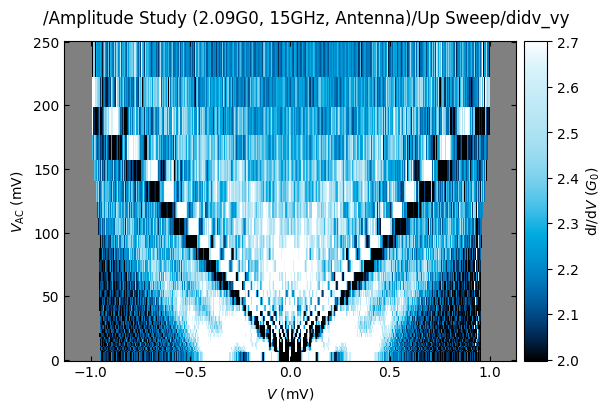

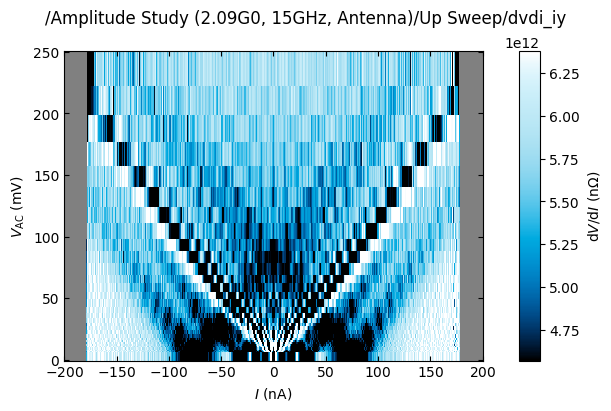

In [3]:
# get exp data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])

eva = IVPlot()
eva.file_directory = '/Volumes/speedyboy/measurement data 2/'
eva.file_folder = '2023-11-03_1_G0/'
eva.file_name = '2023-11-04_G0_antenna.hdf5'

eva.setAmplifications(10000, 1000)
eva.setV(5.99*V_gap, voltage_bins=1198)
eva.setI(200e-9, current_bins=1000)
eva.setA(0, 0.25, 250)
eva.downsample_frequency = 43

# Amplitude Study (2.09, 15GHz, Antenna)
eva.title = "Amplitude Study (2.09G0, 15GHz, Antenna)"
eva.sub_folder = ""
eva.data_folder = "exp_data"

# eva.setMeasurement("frequency_at_15GHz")
# eva.setKeys(index_0=3, index_1=-3, norm=1, to_pop = 'nu=-31.0dBm')
# eva.showKeys()
# eva.addKey('nu=-31.0dBm', -1000)
# eva.up_sweep, = eva.getMaps([1])
# eva.up_sweep, = eva.getMapsAmplitude([eva.up_sweep])
# eva.y_axis = eva.amplitude_axis
# eva.saveData()

eva.loadData()
eva.figure_folder = "exp_data"
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$V_\mathrm{AC}$", "V"]
eva.smoothing = True
eva.window_length = 5
eva.plot_T = False
eva.plot_all()

I_exp = eva.up_sweep['current']*h/(2*e*Delta)

dIdV_exp = eva.up_sweep["differential_conductance"]
V_bias_exp = eva.mapped["voltage_axis"]
V_AC = eva.mapped["amplitude_axis"]

I_0_exp = I_exp[0,:]
I_0_exp[1106] = np.nan
dIdV_0_exp = dIdV_exp[0, :]
V_0_exp = np.linspace(-5.99, 5.99, 1199, dtype='float64')

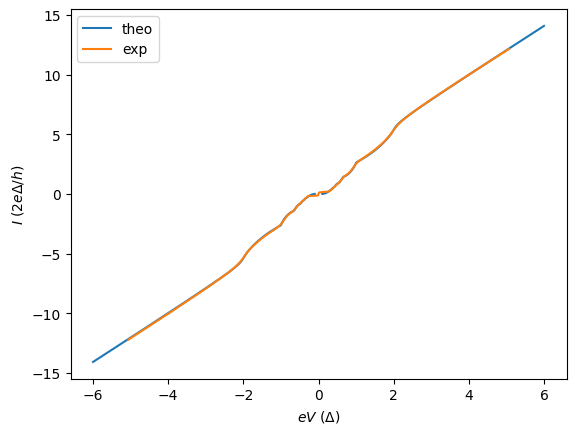

In [4]:
# plot I(V)

with open("DavidOIV/DavidOIV.pickle", "rb") as file:
    theo = pickle.load(file)

tau = theo['tau']
tau_indices = np.zeros(np.shape(pincode), dtype='int')
for i, pin in enumerate(pincode):
    tau_indices[i] = np.argmin(np.abs(tau-pin))
    if np.nanmin(np.abs(tau-pin)) != 0:
        print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

V_0_theo = theo['V']
I_0_theo = np.sum(theo['I'][tau_indices,:], axis=0)
dIdV_0_theo = np.gradient(I_0_theo, V_0_theo)

%matplotlib inline
plt.plot(V_0_theo, I_0_theo, label='theo')
plt.plot(V_0_exp, I_0_exp, label='exp')
x = plt.xlabel(r'$eV$ ($\Delta$)')
y = plt.ylabel(r'$I$ ($2e\Delta/h$)')

l = plt.legend()

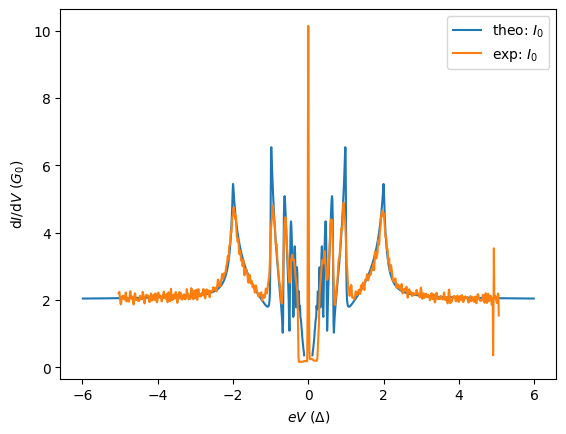

In [5]:
# plot dIdV(V)

with open("DavidOIV/DavidOIV.pickle", "rb") as file:
    theo = pickle.load(file)

tau = theo['tau']
tau_indices = np.zeros(np.shape(pincode), dtype='int')
for i, pin in enumerate(pincode):
    tau_indices[i] = np.argmin(np.abs(tau-pin))
    if np.nanmin(np.abs(tau-pin)) != 0:
        print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

V_0_theo = theo['V']
I_0_theo = np.sum(theo['I'][tau_indices,:], axis=0)
dIdV_0_theo = np.gradient(I_0_theo, V_0_theo)

%matplotlib inline
plt.plot(V_0_theo, dIdV_0_theo, label='theo: $I_0$')
plt.plot(V_0_exp, dIdV_0_exp, label='exp: $I_0$')
x = plt.xlabel(r'$eV$ ($\Delta$)')
y = plt.ylabel(r'd$I/$d$V$ ($G_0$)')
l = plt.legend()

# Tien Gordon Model (exp)
$$
I(\tau_i, V_0, V_\nu) = \sum_{n=-N}^N J_n^2\left(\frac{eV_\nu}{h\nu}\right) \cdot I_{0, exp} \left(\frac{eV_0}{\Delta} - n\cdot\frac{h\nu}{\Delta} \right)
$$

In [6]:
def extrapolate_linear_1d(arr):
    x = np.arange(len(arr))
    mask = ~np.isnan(arr)

    if np.sum(mask) < 2:
        raise ValueError("Need at least two non-NaN values for linear extrapolation")

    x_valid = x[mask]
    y_valid = arr[mask]

    # Interpolation + extrapolation
    from scipy.interpolate import interp1d
    f = interp1d(x_valid, y_valid, kind="linear", fill_value="extrapolate")
    return f(x)

def get_Tien_Gordon_exp(
        V_nu: NDArray[np.float64],
        V_0: NDArray[np.float64],
        I_0_exp: NDArray[np.float64],
        nu: float,
        N:int = 400,
        ):
    
    # constants
    h = 6.62607015e-34  # V * A * s²
    e = 1.602176634e-19 #     A * s
    Delta = V_gap * e   # V * A * s

    # Tien Gordon
    I_TG = np.full((V_nu.shape[0], V_0.shape[0]), 0, dtype='float64')

    I_0 = np.copy(I_0_exp)
    I_0 = extrapolate_linear_1d(I_0)

    interpolated_I = interp1d(
        V_0, 
        I_0, 
        kind='linear', 
        bounds_error=False, 
        fill_value='extrapolate',
        )
    
    # sum over photons
    for n in range(-N, N+1):
        # Bessel function squared (n)
        J_n_2 = jv(n, V_nu)**2

        # Shift I_0 by n
        V_n = n*h*nu/(Delta)
        I_n = interpolated_I(V_0 - V_n)

        # Calculate the n'th current 
        I_n, J_n_2 = np.meshgrid(I_n, J_n_2)

        # Sum up current
        I_TG += J_n_2 * I_n
    
    return I_TG

# Tien Gordon Model
$$
I(\tau_i, V_0, V_\nu) = \sum_{\tau_i} \sum_{n=-N}^N J_n^2\left(\frac{eV_\nu}{h\nu}\right) \cdot I_0 \left(\tau_i, \frac{eV_0}{\Delta} - n\cdot\frac{h\nu}{\Delta} \right)
$$

In [7]:
def get_Tien_Gordon(
        V_nu: NDArray[np.float64],
        pincode: NDArray[np.float64],
        nu: float,
        model: str = 'CarlosIV',
        V_gap: float = 189e-6,
        N:int = 400,
        ):
    
    # constants
    h = 6.62607015e-34  # V * A * s²
    e = 1.602176634e-19 #     A * s
    Delta = V_gap * e   # V * A * s
    
    # models
    models = ['CarlosIV', 'DavidOIV']
    match model:
        case 'CarlosIV':
            with open("CarlosIV/CarlosIV.pickle", "rb") as file:
                IVs = pickle.load(file)
        case 'DavidOIV':
            with open("DavidOIV/DavidOIV.pickle", "rb") as file:
                IVs = pickle.load(file)
        case _:
            raise KeyError (f"Unknown model, Expected: {models}")
        
    tau = IVs['tau']
    tau_indices = np.zeros(np.shape(pincode), dtype='int')
    for i, pin in enumerate(pincode):
        tau_indices[i] = np.argmin(np.abs(tau-pin))
        if np.nanmin(np.abs(tau-pin)) != 0:
            print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

    # Tien Gordon
    V_0 = IVs['V']
    I_TG = np.full((V_nu.shape[0], V_0.shape[0]), 0, dtype='float64')

    # sum over channels
    for index, tau_index in enumerate(tau_indices):
        I_0 = IVs['I'][tau_index, :]
        I_0[np.isnan(I_0)]=0.
        interpolated_I = interp1d(
            V_0, 
            I_0, 
            kind='linear', 
            bounds_error=False, 
            fill_value='extrapolate',
            )
        
        # sum over photons
        for n in range(-N, N+1):
            # Bessel function squared (n)
            J_n_2 = jv(n, V_nu)**2

            # Shift I_0 by n
            V_n = n*h*nu/(Delta)
            I_n = interpolated_I(V_0 - V_n)

            # Calculate the n'th current 
            I_n, J_n_2 = np.meshgrid(I_n, J_n_2)

            # Sum up current
            I_TG += J_n_2 * I_n
        
    return V_0, I_TG        
    

V_0, I_TG = get_Tien_Gordon(
        V_nu = np.linspace(0, 25, 401, dtype='float64'),
        pincode=np.array([ 0.1, .005]),
        nu = 15e9,
        model='DavidOIV',
    )


pincode entry 0.005 is approximated with 0.


# PAMAR
$$
I(\{\tau_i\}, V_0, V_\nu) = \sum_{\{\tau_i\}} \sum_{m=1}^M \sum_{n=-N}^N J_n^2\left(m \cdot \frac{eV_\nu}{h\nu}\right) \cdot I_{0, m} \left(\tau_i, \frac{eV_0}{\Delta} - \frac{n}{m}\cdot\frac{h\nu}{\Delta} \right)
$$

In [8]:
# def get_PAMAR(
#         V_nu: NDArray[np.float64],
#         pincode: NDArray[np.float64],
#         nu: float,
#         model: str = 'DavidOIV',
#         V_gap: float = 189e-6,
#         N: int = 20,
#         M: int = 19,
#         ):
    
#     # constants
#     h = 6.62607015e-34  # V * A * s²
#     e = 1.602176634e-19 #     A * s
#     Delta = V_gap * e   # V * A * s
    
#     # models
#     models = ['DavidOIV']
#     match model:
#         case 'DavidOIV':
#             with open("DavidOIV/DavidOIV.pickle", "rb") as file:
#                 IVs = pickle.load(file)
#         case _:
#             raise KeyError (f"Unknown model, Expected: {models}")
        
#     tau = IVs['tau']
#     tau_indices = np.zeros(np.shape(pincode), dtype='int')
#     for i, pin in enumerate(pincode):
#         tau_indices[i] = np.argmin(np.abs(tau-pin))
#         if np.nanmin(np.abs(tau-pin)) != 0:
#             print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

#     # Tien Gordon
#     V_0 = IVs['V']
#     I_TG = np.full((V_nu.shape[0], V_0.shape[0]), 0, dtype='float64')

#     # sum over channels
#     for index, tau_index in enumerate(tqdm(tau_indices)):
#         I_0_m = IVs['I_m'][tau_index, :]
#         I_0_m[np.isnan(I_0_m)]=0.

#         # sum over charges
#         for i_m, m in enumerate(np.arange(1, M+1)):

#             # define interpolate
#             I_m_ip = interp1d(
#                 V_0, 
#                 I_0_m[i_m], 
#                 kind='linear', 
#                 bounds_error=False, 
#                 fill_value='extrapolate',
#                 )

#             # sum over photons
#             for i_n, n in enumerate(np.arange(-N,N+1)):

#                 # Bessel function squared (n)
#                 J_n_m_2 = jv(n, m*V_nu)**2

#                 # Shift I_0 by n/m
#                 V_n_m = n/m*h*nu/Delta
#                 I_n_m = I_m_ip(V_0 + V_n_m)

#                 # Calculate the n'th current 
#                 I_n_m, J_n_m_2 = np.meshgrid(I_n_m, J_n_m_2)

#                 # Sum up current
#                 I_TG += I_n_m * J_n_m_2
        
#     return V_0, I_TG

# PAMAR 2
$$
I(\{\tau_i\}, V_0, V_\nu) = \sum_{m=1}^M \sum_{n=-N}^N J_n^2\left(\frac{m}{2} \cdot \frac{eV_\nu}{h\nu}\right) \cdot \sum_{\{\tau_i\}} I_{0}\left(m, \tau_i,\frac{eV_0}{\Delta} - \frac{2n}{m}\cdot\frac{h\nu}{\Delta} \right)
$$

In [9]:
def get_PAMAR(
        V_nu: NDArray[np.float64],
        pincode: NDArray[np.float64],
        nu: float,
        model: str = 'DavidOIV',
        V_gap: float = 189e-6,
        N: int = 20,
        M: int = 19,
        ):
    
    # constants
    h = 6.62607015e-34  # V * A * s²
    e = 1.602176634e-19 #     A * s
    Delta = V_gap * e   # V * A * s
    
    # models
    models = ['DavidOIV']
    match model:
        case 'DavidOIV':
            with open("DavidOIV/DavidOIV.pickle", "rb") as file:
                IVs = pickle.load(file)
        case _:
            raise KeyError (f"Unknown model, Expected: {models}")
        
    tau = IVs['tau']
    tau_indices = np.zeros(np.shape(pincode), dtype='int')
    for i, pin in enumerate(pincode):
        tau_indices[i] = np.argmin(np.abs(tau-pin))
        if np.nanmin(np.abs(tau-pin)) != 0:
            print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

    V_0 = IVs['V']
    I_PAMAR = np.full((V_nu.shape[0], V_0.shape[0]), 0, dtype='float64')

    # sum over photons
    for i_n, n in enumerate(tqdm(np.arange(0, N+1))):
        # sum over charges
        for i_m, m in enumerate(np.arange(1, M+1)):

            I_0_m = np.zeros(V_0.shape, dtype='float64')
            
            # sum over channels
            for index, tau_index in enumerate(tau_indices):
                I_0_m_i = IVs['I_m'][tau_index, i_m, :]
                I_0_m_i[np.isnan(I_0_m_i)]=0
                I_0_m += I_0_m_i

            
            # Shift I_0 by n/m
            if n != 0:
                # define interpolate
                I_m_ip = interp1d(
                    V_0, 
                    I_0_m, 
                    kind='linear', 
                    bounds_error=False, 
                    fill_value='extrapolate',
                    )
                V_n_m = 2*n/m*h*nu/Delta
                I_0_m = I_m_ip(V_0 + V_n_m) + I_m_ip(V_0 - V_n_m)

            # Bessel function squared (n)
            J_n = jv(n, m/2*V_nu)**2

            # Calculate the n'th current 
            I_m_mesh, J_n_mesh = np.meshgrid(I_0_m, J_n)

            # Sum up current
            I_PAMAR += I_m_mesh * J_n_mesh
    
    return V_0, I_PAMAR

# Calculate Simulations

In [10]:
M, N = 20, 500
V_nu = np.linspace(0, 25, 251, dtype='float64')
nu = 15e9

In [11]:
V_0_theo, I_PAMAR = get_PAMAR(
        V_nu = V_nu,
        pincode = pincode,
        nu = nu,
        model = 'DavidOIV',
        M = M, 
        N = N,
    )
dIdV_PAMAR = np.gradient(I_PAMAR, V_0_theo, axis=1)

100%|██████████| 501/501 [00:10<00:00, 45.92it/s]


In [12]:
V_0_theo, I_TG_theo = get_Tien_Gordon(
        V_nu = V_nu,
        pincode = pincode,
        nu = nu,
        model = 'DavidOIV',
        N = N,
    )
dIdV_TG_theo = np.gradient(I_TG_theo, V_0_theo, axis=1)

In [13]:
I_TG_exp = get_Tien_Gordon_exp(
        V_0 = V_0_exp,
        V_nu = V_nu,
        I_0_exp = I_0_exp,
        nu = nu,
        N = N,
    )
dIdV_TG_exp = np.gradient(I_TG_exp, V_0_exp, axis=1)


In [14]:
clim = (0, 6)
xlim = (-2.8, 2.8)
ylim = (0, 7)
# ylim = (None, None)
# xlim=(None, None)

In [17]:
# Plot all
%matplotlib qt

V_nu_step = V_nu[-1]-V_nu[-2]
V_0_step = V_0_exp[-1]-V_0_exp[-2]
ext = (V_0_exp[0]-V_0_step/2, V_0_exp[-1]+V_0_step/2, V_nu[0]-V_nu_step/2, V_nu[-1]+V_nu_step/2)

plt.close(0)
fig = plt.figure(0,constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=[3, 3],
                          height_ratios=[.5, 3, 3])
ax_info = fig.add_subplot(spec[0,0])
ax_info.axis("off")
cax = fig.add_subplot(spec[0,1])
ax_exp = fig.add_subplot(spec[1,0])
ax_TG_exp = fig.add_subplot(spec[1,1])
ax_TG_theo = fig.add_subplot(spec[2,0])
ax_PAMAR = fig.add_subplot(spec[2,1])

fig.suptitle('Comparation of Exp Data and Tien-Gordon Models')
ax_exp.set_title('exp')
ax_TG_exp.set_title('TG_exp')
ax_TG_theo.set_title('TG_theo')
ax_PAMAR.set_title('PAMAR')

ax_info.text(
    0.01, 0.95,
    rf"$\tau_i = ${pincode},"+"\n"+rf"$G = ${np.sum(pincode)}$\,G_0, \nu = ${nu*1e-9:.1f}$\,$GHz",
    ha='left', va='top', fontsize=12, wrap=True,
    # bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.5')
)


dIdV = [dIdV_exp, dIdV_TG_exp, dIdV_TG_theo, dIdV_PAMAR]

for i, ax in enumerate([ax_exp, ax_TG_exp, ax_TG_theo, ax_PAMAR]):
    im = ax.imshow(
        dIdV[i], 
        aspect='auto', 
        origin='lower', 
        clim=clim, 
        extent=ext, 
        interpolation=None,
        cmap=cmap(bad="grey"),
        )

    if ax != ax_exp:
        ax.sharex(ax_exp)
        ax.sharey(ax_exp)

    ax.tick_params(
        direction='in',       # Ticks nach innen
        top=True,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(r'$eV_\nu$ (arb. units)')
    ax.set_xlabel(r'$eV_0$ ($\Delta$)')

cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_label_position('top')  # place label above the bar
cbar.ax.xaxis.set_ticks_position('top')  # keep ticks below
cbar.set_label(r'd$I/$d$V$ ($G_0$)', labelpad=10, loc="center")

ax_exp.tick_params(labelbottom=False)
ax_exp.set_xlabel('')
ax_TG_exp.tick_params(labelbottom=False)
ax_TG_exp.set_xlabel('')
ax_TG_exp.yaxis.tick_right()                  # move ticks to right
ax_TG_exp.yaxis.set_label_position("right") 
ax_PAMAR.yaxis.tick_right()                  # move ticks to right
ax_PAMAR.yaxis.set_label_position("right") 

plt.savefig("TG 2.09 G0 (15GHz).png", dpi=300, bbox_inches='tight')